In [23]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [24]:
dataset_dir = './dataset/training'

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

In [25]:
%%script false --no-raise-error
num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


In [26]:
SEED = 19011997
SPLIT_VAL = 0.2
SPLIT_TEST = 0.06
BATCH_SIZE = 128
IMG_SIZE = (256,256)

## Dataset statistics

Total count: 17728
Apple count: 988
Blueberry count: 467
Cherry count: 583
Corn count: 1206
Grape count: 1458
Orange count: 1748
Peach count: 977
Pepper count: 765
Potato count: 716
Raspberry count: 264
Soybean count: 1616
Squash count: 574
Strawberry count: 673
Tomato count: 5693


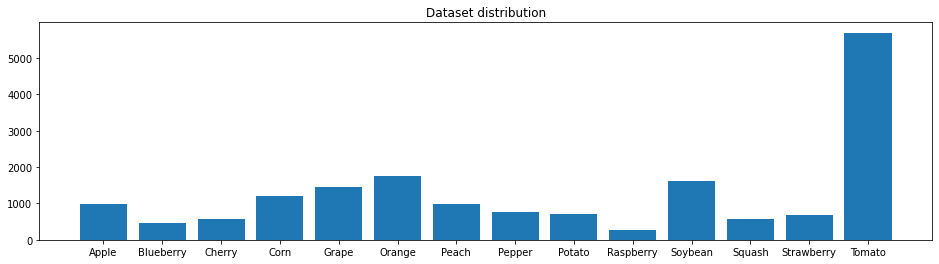

In [27]:
import pathlib

dataset_dir_path = pathlib.Path(dataset_dir)
images_count_total = len(list(dataset_dir_path.glob('*/*.jpg')))
print('Total count: {}'.format(images_count_total))
images_count = {}
for label in labels:
    count = len(list(dataset_dir_path.glob('{}/*.jpg'.format(label))))
    images_count[label] = count
    print('{} count: {}'.format(label, count))
plt.figure(figsize=(16,4))
plt.bar(range(len(labels)), list(images_count.values()))
plt.xticks(range(len(labels)), labels)
plt.title('Dataset distribution')
plt.show()

In [28]:
max_class = max(images_count.values())
class_weights = {}
i = 0
for k,v in images_count.items():
    class_weights[i] = max_class/v
    i += 1
print(class_weights)

{0: 5.762145748987854, 1: 12.190578158458244, 2: 9.76500857632933, 3: 4.720563847429519, 4: 3.904663923182442, 5: 3.2568649885583523, 6: 5.827021494370522, 7: 7.441830065359477, 8: 7.951117318435754, 9: 21.564393939393938, 10: 3.5228960396039604, 11: 9.918118466898955, 12: 8.459138187221397, 13: 1.0}


## Load data

[tutorial](https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility)

In [40]:
import tensorflow as tf
import math

# def import_dataset():
#     return tf.keras.preprocessing.image_dataset_from_directory(
#         dataset_dir,
#         labels='inferred',
#         label_mode='categorical',
#         class_names=labels,
#         color_mode='rgb',
#         batch_size=BATCH_SIZE,
#         image_size=IMG_SIZE,
#         shuffle=True,
#         seed=SEED,
#         validation_split=None,
#         subset=None,
#         interpolation='bilinear',
#         follow_links=False,
#         crop_to_aspect_ratio=False
#     )

def import_dataset():
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=360,
        width_shift_range=0.0,
        height_shift_range=0.0,
        brightness_range=None,
        shear_range=0.0,
        zoom_range=0.0,
        channel_shift_range=0.0,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0,
        dtype=None
    )

    return datagen.flow_from_directory(dataset_dir, target_size=IMG_SIZE, class_mode='categorical')

dataset_all = import_dataset()

batches_total = math.floor(len(dataset_all))
batches_test = math.floor(batches_total * SPLIT_TEST)
batches_validation = math.floor((batches_total - batches_test) * SPLIT_VAL)

dataset_val_training = dataset_all.skip(batches_test)
dataset_training = dataset_val_training.skip(batches_validation)
dataset_validation = dataset_val_training.take(batches_validation)
dataset_test = dataset_all.take(batches_test)

print(len(dataset_test), len(dataset_validation), len(dataset_training))
print(len(dataset_test) * BATCH_SIZE, len(dataset_validation) * BATCH_SIZE, len(dataset_training) * BATCH_SIZE)

#dataset_training = import_dataset('training')
#dataset_validation = import_dataset('validation')

dataset_test = dataset_test.prefetch(buffer_size=64)
dataset_training = dataset_training.prefetch(buffer_size=64)
dataset_validation = dataset_validation.prefetch(buffer_size=64)

Found 17728 images belonging to 14 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'skip'

**Dataset shape** `((batch, width?, height?, channels), (batch, classes))`

In [30]:
%%script false --no-raise-error
plt.figure(figsize=(10, 10))
for images, onehot in dataset_training.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(np.array(onehot[i]), axis=0)
    plt.title(labels[index])
    plt.axis("off")

Couldn't find program: 'false'


[tutorial](https://keras.io/examples/vision/image_classification_from_scratch/)

In [31]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.5, fill_mode='constant') # oppure "nearest"
    ]
)

In [34]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    #x = data_augmentation(inputs)
    x = inputs
    x = tf.keras.layers.Rescaling(1./255)(x)

    x = tf.keras.layers.Conv2D(16, 5, strides=3, padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [35]:
model = make_model(IMG_SIZE + (3,), len(labels))

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 86, 86, 16)        1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 16)       0         
 2D)                                                             
                                                                 
 activation_3 (Activation)   (None, 43, 43, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 43, 43, 32)        4640      
                                                           

In [37]:
EPOCHS = 1
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
callbacks = [
    #tf.keras.callbacks.ModelCheckpoint("./checkpoints/save_at_{epoch}.h5"),
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)
model.fit(
    dataset_training, epochs=EPOCHS, callbacks=callbacks, validation_data=dataset_validation, class_weight=class_weights
)

105/105 [==============================] - 26s 166ms/step - loss: 8.1296 - accuracy: 0.3972 - mse: 0.0520 - val_loss: 1.4563 - val_accuracy: 0.5312 - val_mse: 0.0433


In [39]:
model.save('./models/asdf')

INFO:tensorflow:Assets written to: ./models/asdf\assets


In [ ]:
model = tf.keras.models.load_model('./model.h5')
model.evaluate(dataset_test)

8/8 [==============================] - 1s 58ms/step - loss: 0.0674 - accuracy: 0.8291


[0.0673886388540268, 0.8291015625]